<a href="https://colab.research.google.com/github/jbrown544/interlingual-topic-modeling/blob/main/Interlingual_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Built with spaCy](https://img.shields.io/badge/built%20with-spaCy-09a3d5.svg)](https://spacy.io)

# Unsupervised Thematic Discovery in Non-English Natural Language Corpora

**Use the "Open in Colab" link above to render visualizations.*

## Processing Environment Initialization

In [1]:
# reduce warnings for publishing

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Environment

In [2]:
# configuration folders

# place your non-ephemeral configuration files in here
%mkdir --parents caches keys

In [3]:
# set environment variable to point to your own service account key

%set_env GOOGLE_APPLICATION_CREDENTIALS=/content/keys/interlingual-topic-modeling.json

env: GOOGLE_APPLICATION_CREDENTIALS=/content/keys/interlingual-topic-modeling.json


In [4]:
# debugging flag for diagnostic outputs
DEBUG = True

### Packages

In [5]:
# update required dependencies

# If you see a message such as this after running pip (bottom of output):
#
# "WARNING: The following packages were previously imported in this runtime:""
# " [ xxxx, xxxxx ]"
# "You must restart the runtime in order to use newly installed versions.""
#
# Please do restart the Python runtime. Neglecting this restart may 
# result in errors during processing due to previously loaded packages.

%pip install -U python-Levenshtein \
                spacy==3.1.2 \
                pyLDAvis==3.3.1 \
                gensim==4.1.2

# pip setuptools wheel

In [6]:
# inspect spaCy package information

%pip show spacy

Name: spacy
Version: 3.1.2
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: spacy-legacy, tqdm, typer, srsly, cymem, pydantic, jinja2, preshed, pathy, typing-extensions, requests, numpy, blis, wasabi, thinc, murmurhash, setuptools, catalogue, packaging
Required-by: fr-core-news-md, fastai, es-core-news-md, en-core-web-sm


In [7]:
# instpect pyLDAvis package information

%pip show pyLDAvis

Name: pyLDAvis
Version: 3.3.1
Summary: Interactive topic model visualization. Port of the R package.
Home-page: https://github.com/bmabey/pyLDAvis
Author: Ben Mabey
Author-email: ben@benmabey.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: setuptools, scikit-learn, numpy, funcy, numexpr, joblib, scipy, jinja2, pandas, sklearn, future, gensim
Required-by: 


In [8]:
# inspect Gensim package information

%pip show gensim

Name: gensim
Version: 4.1.2
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, scipy, smart-open
Required-by: pyLDAvis


## Data Environment Initialization

### Dependencies

In [9]:
# import dependencies

import json
from urllib.parse import urljoin
from os.path import exists
from collections import Counter

import spacy

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from gensim import corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.test.utils import get_tmpfile

from smart_open import open

from google.cloud import translate_v2 as translate

import matplotlib.pyplot as plt 

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more 

In [10]:
# enable visualizations inline

pyLDAvis.enable_notebook()

### Translation Tools

#### Translation Caching

In [11]:
xlat_cache_file_name = '/content/caches/xlat.json'

In [12]:
# translation cache: loading

def load_translation_cache():  
  """ 
  Return a translation cache populated with previously persisted dictionaries.
  """
  
  xlat_cache = {}

  if exists(xlat_cache_file_name):
    with open(xlat_cache_file_name) as f:
        xlat_cache = json.load(f)

    if DEBUG:
      print(f'"{xlat_cache_file_name}" xlat cache loaded:')
      for lang in xlat_cache:
        print(f'\t[{lang}] contains {len(xlat_cache[lang])} entries')

  return xlat_cache

In [13]:
# translation cache: saving

def save_translation_cache(dirty_xlat_cache):
  """
  Save a translation cache overwriting any previously persisted dictionaries.

  Keyword arguments:
      dirty_xlat_cache -- a dirty translation cache
  """

  with open(xlat_cache_file_name, 'w') as f:
    json.dump(dirty_xlat_cache, f)

  if DEBUG:
    print(f'"{xlat_cache_file_name}" xlat cache persisted.',
          'Please make a non-ephemeral copy!!!')

In [14]:
# translation cache: extending

def extend_translation_cache(terms,
                      source_language,
                      target_language='en'):  
  """
  Extend a translation cache resolving any unknown terms using a cloud 
  translator. Return the number of cache misses and the translation dictionary 
  for the specified source language containing at least the requested terms.

  Keyword arguments:
      terms -- sequence of terms to warm in cache
      source_language -- the language of terms
      target_language -- the target language for term translation
  """

  xlat_cache = load_translation_cache()

  # get or create a dictionary for the specified language mapping
  xlat_dict = xlat_cache.setdefault(f'{source_language}->{target_language}', {})

  cache_terms = [term for term in terms if term not in xlat_dict]

  # if there are uknown terms, resolve them with cloud translation
  if len(cache_terms) > 0:

    print(f'Translating {len(cache_terms)} terms.')

    translate_client = translate.Client(target_language=target_language)

    # the cloud translation API processes lists of a finite length so
    # terms requiring resolution are batched into 128 per call
    batch_size = 128

    # process terms in batches storing results into the translation dictionary
    for i in range(0, len(cache_terms), batch_size):
      for result in translate_client.translate(cache_terms[i:i+batch_size],
                                               source_language=source_language):
        xlat_dict[result['input']] = result['translatedText']
    
    save_translation_cache(xlat_cache)

  return len(cache_terms), xlat_dict

#### Gensim Dictionary Translation

In [15]:
# gensim dictionary: loading

def load_gensim_dict_file(dict_file):
  """
  Load the entries of a gensim dictionary file then return a tuple
  containing read document count and list of entries.

  Keyword arguments:
      dict_file -- gensim dictionary file
  """

  entries = []

  with open(dict_file) as f:
    num_docs = f.readline().strip()
    line = f.readline().strip()
    while line != '':
      entries.append(line.split('\t'))
      line = f.readline().strip()

  return num_docs, entries

In [16]:
# gensim dictionary: saving

def save_gensim_dict_file(dict_file, gensim_dict_entries):
  """
  Save the entries of a gensim dictionary to a file.

  Keyword arguments:
      dict_file -- gensim dictionary file
      gensim_dict_entries -- list of (id, term, frequency) entries
  """

  num_docs, entries = gensim_dict_entries

  with open(dict_file, 'w') as f:
    f.write(num_docs)
    f.write('\n')
    for entry in entries:
      f.write('\t'.join(map(str, entry)))
      f.write('\n')

In [17]:
# gensim dictionary: individual entry translation

def translate_gensim_dictionary_entries(gensim_dict_entries,
                                        source_language,
                                        target_language='en'):
  """
  Returns the number of translation cache misses and a new list of gensim 
  dictionary entries having terms augmented with translations.

  Keyword arguments:
      gensim_dict_entries -- list of (id, term, frequency) entries
      source_language -- the language of entry terms
      target_language -- the target language for entry term translation
  """

  num_docs, entries = gensim_dict_entries

  # extend the cache with the requested terms
  misses, xlat_dict = \
    extend_translation_cache([term for id, term, freq in entries],
                             source_language, target_language)

  # created augmented dictionary entries
  entries = entries.copy()
  for i in range(len(entries)):
    entries[i][1] = f"{xlat_dict[entries[i][1]]} ({entries[i][1]})"

  return misses, (num_docs, entries)

In [18]:
# gensim dictionary: dictionary translation

def translate_gensim_dictionary(gensim_dictionary, 
                                source_language,
                                target_language='en'):
  """
  Returns the number of translation cache misses and a new gensim dictionary 
  with entries augmented with their target language translations.

  Keyword arguments:
      gensim_dict_entries -- list of (id, term, frequency) entries
      source_language -- the language of entry terms
      target_language -- the target language for entry term translation
  """

  # convert dictionary to entries structure by way of temp file
  dict_file = get_tmpfile('dict_file')
  gensim_dictionary.save_as_text(dict_file)
  gensim_dict_entries = load_gensim_dict_file(dict_file)

  # augment the entries structure with translations
  misses, xlat_entries = translate_gensim_dictionary_entries(
      gensim_dict_entries, source_language, target_language)

  # convert entries structure to dictionary by way of temp file
  xlat_dict_file = get_tmpfile('xlat_dict_file')
  save_gensim_dict_file(xlat_dict_file, xlat_entries)  
  return misses, corpora.Dictionary().load_from_text(xlat_dict_file)

#### Translation Test

In [19]:
# test translate a small dictionary

misses, translated_test_dict = \
  translate_gensim_dictionary(corpora.Dictionary([['crayon', 'stylo']]), 'fr')

# Check we have a previously populated dictionary.
# This check helps ensure we are not forgetting 
# to install our non-ephemeral translation dictionary.
assert misses == 0

print(translated_test_dict)

"/content/caches/xlat.json" xlat cache loaded:
	[fr->en] contains 14864 entries
	[es->en] contains 10177 entries
Dictionary(2 unique tokens: ['pencil (crayon)', 'pen (stylo)'])


### Language-Neutral Processing Pipeline

#### Install spaCy Models

In [20]:
# install data sets required for spaCy statistical models

%run -m spacy download fr_core_news_md
%run -m spacy download es_core_news_md

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


#### Create spaCy Processing Pipelines

In [21]:
# spaCy model parameters

load_params = dict(
    exclude=['parser', 'ner']
)

In [22]:
# load language model and inspect pipeline: French

fr_nlp = spacy.load('fr_core_news_md', **load_params)

print("Pipeline:", fr_nlp.pipe_names)

Pipeline: ['tok2vec', 'morphologizer', 'attribute_ruler', 'lemmatizer']


In [23]:
# load language model and inspect pipeline: Spanish

es_nlp = spacy.load('es_core_news_md', **load_params)

print("Pipeline:", es_nlp.pipe_names)

Pipeline: ['tok2vec', 'morphologizer', 'attribute_ruler', 'lemmatizer']


#### Basic Preprocessing

In [24]:
# basic text preprocessing

def basic_preprocess(texts,
                     deaccent=False,
                     min_token_length=2,
                     max_token_length=15):
  """
  Perform basic (faster) preprocessing on a list of texts returning the 
  tokenized results.

  Processing consists of tokenizization, lowercasing, filtering tokens to a
  length range and optionally removing accenting marks.

  Keyword arguments:
      texts -- strings containing source texts
      deaccent -- remove accents from characters
      min_token_length -- the minimum token length to retain
      max_token_length -- the maximum token length to retain
  """

  return [simple_preprocess(text, deacc=deaccent,
                     min_len=min_token_length,
                     max_len=max_token_length)
  for text in texts]

#### Advanced Preprocessing

In [25]:
# advanced text preprocessing

def advanced_preprocess(nlp, 
                        texts,
                        min_token_length=2,
                        max_token_length=15,
                        processors=1):
  """
  Perform more advanced (slower) preprocessing on a list of texts returning the 
  tokenized results.

  Processing consists of tokenizization, lowercasing, filtering tokens to a
  length range, filtering by high-value parts of speech (nouns, verbs, etc.),
  filtering non-alphabetic terms, and filtering language specific stopwords.

  Keyword arguments:
      nlp -- spaCy language model appropriate for texts
      texts -- list of strings containing language texts      
      min_token_length -- the minimum token length to retain
      max_token_length -- the maximum token length to retain
      processors -- count of CPUs to employ; (-1=all) use with caution!
  """

  # SpaCy's NLP processing pipeline extracts 'features' from text
  # useful for selecting the more valuable terms. 
  # Here, only parts-of-speech listed are preserved.
  keep_pos = {'NOUN', 'VERB', 'ADJ', 'ADV'}
  
  return [[token.lemma_.lower() for token in doc
           if token.pos_ in keep_pos
           and token.is_alpha and not token.is_stop
           and len(token.lemma_) >= min_token_length
           and len(token.lemma_) <= max_token_length]
          for doc in nlp.pipe(texts, n_process=processors)]

#### Text Exploratory Data Analysis (EDA)

In [26]:
def corpus_eda(nlp, texts,
               target_language='en',
               processors=1):
  """
  Print a report of various EDA statistics on a corpus. 
  
  The corpus can be in any language provided a document model is available 
  to process its contents.

   Keyword arguments:
      nlp -- spaCy language model appropriate for texts
      texts -- list of strings containing language texts
      target_language -- the target language for text translation
      processors -- count of CPUs to employ; (-1=all) use with caution!
  """

  doc_count = 0
  sent_count = 0
  token_count = 0
  word_count = 0
  unique_word_counter = Counter()
  word_pos_counter = Counter()
  
  # enable the fast statistical sentence bounder
  nlp.enable_pipe('senter')

  # iterate documents and aggregate various measures
  for doc in nlp.pipe(texts, n_process=processors):

    doc_count += 1

    for sent in doc.sents:

      sent_count += 1
      token_count += len(sent)

      words = [token for token in sent if token.is_alpha]
      word_count += len(words)
      unique_word_counter.update([word.text for word in words])
      word_pos_counter.update([word.pos_ for word in words])

  # disable sentence bounder
  nlp.disable_pipe('senter')

  # report various statistics

  print('----')

  print(f'Document count: {doc_count:,}')
  print(f'POS count: {len(word_pos_counter):,}')
  print(f'Sentence count: {sent_count:,}')
  print(f'Token count: {token_count:,}')
  print(f'Word count: {word_count:,}')
  print(f'Unique Word count: {len(unique_word_counter):,}')
  
  print('----')

  print(f'Avg. Tokens/Sentence: {round(token_count/sent_count, 2):,}')
  print(f'Avg. Words/Sentence: {round(word_count/sent_count, 2):,}')

  print(f'Avg. Tokens/Document: {round(token_count/doc_count, 2):,}')  
  print(f'Avg. Words/Document: {round(word_count/doc_count, 2):,}')

  print(f'Avg. Sentences/Document: {round(sent_count/doc_count, 2):,}')
  
  print('----')
  
  plt.xticks(rotation=90)
  plt.bar(word_pos_counter.keys(), word_pos_counter.values())
  plt.show()
  print('POS Tags: https://universaldependencies.org/docs/u/pos/')
  
  # wordcloud for n-grams? or noun chunks?

  print('----')
    
  top_words = unique_word_counter.most_common(100)

  # extend the translation cache with top words
  misses, xlat_dict = extend_translation_cache([word \
                                                for word, count in top_words],
                                               nlp.lang, 
                                               target_language)
  
  print(f'100 most common Words:',
        [(f'{xlat_dict[word]} ({word})', count) for word, count in top_words])

  # print(f'20 most common POS: {pos_counter.most_common(20)}')  

## French Language Samples

Original documents may be found at [ABU: la Bibliothèque Universelle](http://abu.cnam.fr/BIB/).

In [27]:
# samples of the French language

# samples are available within this repository
french_book_url = ('https://raw.githubusercontent.com/jbrown544/'
                   'interlingual-topic-modeling/main/text/books/fr/')

# characteristics: few, lengthy documents with informational headers intact
jules_verne_french_books = [
  'Five_Weeks_in_a_Balloon.txt',
  'Around_the_World_in_Eighty_Days.txt',
  'Robur_the_Conqueror.txt',
  'From_the_Earth_to_the_Moon.txt',  
  'The_Begums_Fortune.txt',
  'The_Blockade_Runners.txt',
  'The_Mutineers_of_the_Bounty.txt'
]

#### Process French Language Samples

In [28]:
# generator for loading encoded French books

%time jules_verne_texts = \
  [open(urljoin(french_book_url, book), \
        encoding='latin-1').read() \
    for book in jules_verne_french_books]

CPU times: user 92.7 ms, sys: 7.76 ms, total: 100 ms
Wall time: 1.68 s


----
Document count: 7
POS count: 17
Sentence count: 25,795
Token count: 441,016
Word count: 335,790
Unique Word count: 25,396
----
Avg. Tokens/Sentence: 17.1
Avg. Words/Sentence: 13.02
Avg. Tokens/Document: 63,002.29
Avg. Words/Document: 47,970.0
Avg. Sentences/Document: 3,685.0
----


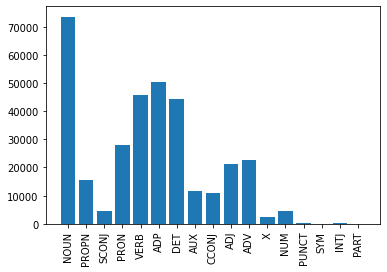

POS Tags: https://universaldependencies.org/docs/u/pos/
----
"/content/caches/xlat.json" xlat cache loaded:
	[fr->en] contains 14864 entries
	[es->en] contains 10177 entries
100 most common Words: [('of (de)', 15735), ('the (la)', 7822), ('To (à)', 7811), ('the (le)', 7494), ('and (et)', 6967), ('the (les)', 5438), ('a (un)', 4656), ('he (il)', 4222), ('in (en)', 3910), ('of (du)', 3699), ('a (une)', 3552), ('from (des)', 3481), ('than (que)', 3375), ('se (se)', 2941), ('in (dans)', 2801), ('born (ne)', 2654), ('who (qui)', 2559), ('not (pas)', 2529), ('is (est)', 2126), ('to (au)', 2062), ('this (ce)', 1990), ('was (était)', 1970), ('more (plus)', 1845), ('his (son)', 1802), ('through (par)', 1644), ('for (pour)', 1620), ('on (sur)', 1619), ('had (avait)', 1408), ('this (cette)', 1311), ('with (avec)', 1263), ('his (ses)', 1211), ('He (Il)', 1210), ('the (Le)', 1154), ('her (sa)', 1145), ('him (lui)', 1136), ('we (nous)', 1073), ('we (on)', 1003), ('you (vous)', 958), ('said (dit)', 9

In [29]:
# generate EDA report
corpus_eda(fr_nlp, jules_verne_texts,
           processors=-1)

In [30]:
# preprocessing parameters

preprocess_params = dict(
    texts=jules_verne_texts, 
    min_token_length=3    
)

In [31]:
# basic preprocessing

%time jules_verne_docs_basic = basic_preprocess(**preprocess_params)

CPU times: user 439 ms, sys: 10.9 ms, total: 450 ms
Wall time: 457 ms


In [32]:
# advanced preprocessing

%time jules_verne_docs_advanced = advanced_preprocess(fr_nlp, \
                                                      **preprocess_params, \
                                                      processors=-1)

CPU times: user 2.7 s, sys: 598 ms, total: 3.29 s
Wall time: 52.5 s


In [33]:
# check the term lengths on docs for grades of preprocessing

print(f'terms basic vs. advanced preprocessing:')
for title, basic, advanced \
 in zip(jules_verne_french_books,
        jules_verne_docs_basic,
        jules_verne_docs_advanced):
  print(f'\t{len(basic)}\tvs.\t{len(advanced)}\t({title})')

terms basic vs. advanced preprocessing:
	59713	vs.	32377	(Five_Weeks_in_a_Balloon.txt)
	51505	vs.	27415	(Around_the_World_in_Eighty_Days.txt)
	43217	vs.	22509	(Robur_the_Conqueror.txt)
	40445	vs.	22174	(From_the_Earth_to_the_Moon.txt)
	38249	vs.	21409	(The_Begums_Fortune.txt)
	13719	vs.	7314	(The_Blockade_Runners.txt)
	5348	vs.	2763	(The_Mutineers_of_the_Bounty.txt)


In [34]:
# use advance output for subsequent processing 

# NOTE: remove the smaller two books?

jules_verne_docs = jules_verne_docs_advanced

print(len(jules_verne_docs))

7


In [35]:
# construct dictionary from processed docs

jules_verne_dictionary = corpora.Dictionary(jules_verne_docs)

print(jules_verne_dictionary)

Dictionary(11668 unique tokens: ['abaissement', 'abaisser', 'abandonne', 'abandonner', 'abat']...)


In [36]:
# filter extremes from the dictionary 
# by removing words that appear too 
# frequently or too rarely

# NOTE: consider only terms in 2 or more docs?

jules_verne_dictionary.filter_extremes(no_below=1,
                                       no_above=0.75,
                                       keep_n=10_000)

print(jules_verne_dictionary)

Dictionary(10000 unique tokens: ['abaissement', 'abandonne', 'abat', 'abattre', 'abattu']...)


In [37]:
# construct corpus (term-document matrix) by converting 
# processed docs into bag-of-words representations

jules_verne_corpus = [jules_verne_dictionary.doc2bow(doc) \
                      for doc in jules_verne_docs]

### HDP Topic Modeling

In [38]:
# construct HDP model

# Online HDP is efficient non-parametric topic modeling that 
# does not require a specified topic count. 

# The "T" parameter restricts the number of topics revealed.

%time jules_verne_hdp_model = models.HdpModel(jules_verne_corpus, \
                                              jules_verne_dictionary, \
                                              T=20)

CPU times: user 382 ms, sys: 209 ms, total: 590 ms
Wall time: 416 ms


In [39]:
# create a translation of the dictionary for presentation

misses, jules_verne_xlat_dictionary = \
  translate_gensim_dictionary(jules_verne_dictionary, 'fr')
  
print(f'{misses} cache misses.')
print(jules_verne_xlat_dictionary)

"/content/caches/xlat.json" xlat cache loaded:
	[fr->en] contains 14864 entries
	[es->en] contains 10177 entries
0 cache misses.
Dictionary(10000 unique tokens: ['lowering (abaissement)', 'abandoned (abandonne)', 'stun (abasourdir)', 'abatement (abat)', 'abatement (abattement)']...)


#### Model Visualization

In [40]:
# prepare model visualization

vis_data = gensimvis.prepare(jules_verne_hdp_model,
                             jules_verne_corpus,
                             jules_verne_xlat_dictionary,
                             mds='tsne')

# pyLDAvis.save_html(model_vis, 'jules_verne_topics.html')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t

In [41]:
# display the visualization inline

pyLDAvis.display(vis_data)

#### Model Evaluation

In [42]:
# evaluate model coherence

coherence_model = models.CoherenceModel(jules_verne_hdp_model,
                                        corpus=jules_verne_corpus,
                                        coherence='u_mass')

print(f'{coherence_model.get_coherence()} coherence')

-8.786199943577206 coherence


In [43]:
# coherence_model.top_topics_as_word_lists(jules_verne_hdp_model,
#                                          jules_verne_xlat_dictionary,
#                                          topn=10)

## Spanish Language Samples

Original documents may be found at [Corpora Collection Leipzig University](https://corpora.uni-leipzig.de/en).

In [44]:
# samples of the Spanish language

# samples are available within this repository
# characteristics: many (100K), short documents taken from RSS news headlines
spanish_news_url = ('https://raw.githubusercontent.com/jbrown544/'
                    'interlingual-topic-modeling/main/text/news/es/'
                    'spa_news_2020_100K-sentences.txt')

#### Process Spanish Language Samples

In [45]:
# generator for loading encoded Spanish news headlines

%time spanish_news_texts = [sentence for id, sentence in \
                            [line.split('\t') for line in \
                             open(spanish_news_url, \
                                  encoding='utf-8').readlines()]]

CPU times: user 207 ms, sys: 72.2 ms, total: 279 ms
Wall time: 1.05 s


----
Document count: 100,000
POS count: 16
Sentence count: 196,078
Token count: 2,681,766
Word count: 2,239,322
Unique Word count: 98,162
----
Avg. Tokens/Sentence: 13.68
Avg. Words/Sentence: 11.42
Avg. Tokens/Document: 26.82
Avg. Words/Document: 22.39
Avg. Sentences/Document: 1.96
----


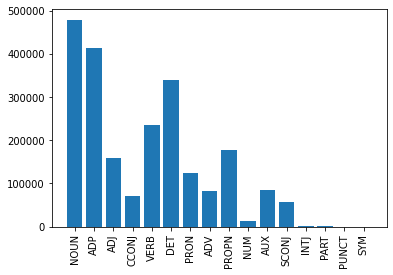

POS Tags: https://universaldependencies.org/docs/u/pos/
----
"/content/caches/xlat.json" xlat cache loaded:
	[fr->en] contains 14864 entries
	[es->en] contains 10177 entries
Translating 87 terms.
"/content/caches/xlat.json" xlat cache persisted. Please make a non-ephemeral copy!!!
100 most common Words: [('from (de)', 153490), ('the (la)', 84175), ('that (que)', 72147), ('the (el)', 64506), ('on (en)', 61996), ('and (y)', 54343), ('to (a)', 46598), ('the (los)', 34162), ('I know (se)', 29067), ('of the (del)', 27943), ('the (las)', 23984), ('a (un)', 23104), ('with (con)', 22090), ('by (por)', 21443), ('for (para)', 20412), ('a (una)', 17783), ('no (no)', 15612), ('it is (es)', 13763), ('its (su)', 13748), ('to the (al)', 12731), ('The (El)', 11578), ('plus (más)', 9959), ('it (lo)', 9918), ('he has (ha)', 9261), ('The (La)', 8860), ('What (como)', 8536), ('On (En)', 7053), ('this (este)', 6747), ('their (sus)', 5427), ('or (o)', 4765), ('it was (fue)', 4368), ('but (pero)', 4339), ('t

In [46]:
# generate EDA report
corpus_eda(es_nlp, spanish_news_texts,
           processors=-1)

In [47]:
# preprocessing parameters

preprocess_params = dict(
    texts=spanish_news_texts, 
    min_token_length=3    
)

In [48]:
# basic preprocessing

%time spanish_news_docs_basic = basic_preprocess(**preprocess_params)

CPU times: user 3.26 s, sys: 115 ms, total: 3.37 s
Wall time: 3.39 s


In [50]:
# advanced preprocessing

%time spanish_news_docs_advanced = advanced_preprocess(es_nlp, \
                                                       **preprocess_params, \
                                                       processors=-1)

CPU times: user 1min 56s, sys: 2.8 s, total: 1min 59s
Wall time: 4min 14s


In [51]:
# check the term lengths on docs for grades of preprocessing

print(f'terms basic vs. advanced preprocessing:')
for  i, (basic, advanced) \
 in enumerate(zip(spanish_news_docs_basic[:10], 
                  spanish_news_docs_advanced[:10])):
    print(f'\t{len(basic)}\tvs.\t{len(advanced)}\t(Line {i+1})')

terms basic vs. advanced preprocessing:
	7	vs.	7	(Line 1)
	3	vs.	1	(Line 2)
	8	vs.	3	(Line 3)
	16	vs.	10	(Line 4)
	23	vs.	9	(Line 5)
	7	vs.	1	(Line 6)
	4	vs.	1	(Line 7)
	8	vs.	3	(Line 8)
	12	vs.	7	(Line 9)
	15	vs.	9	(Line 10)


In [59]:
# use advance output for subsequent processing 

# eliminate documents which were parsed into too few tokens
spanish_news_docs = [doc for doc in spanish_news_docs_advanced if len(doc) > 3]

print(len(spanish_news_docs))

85582


In [60]:
# construct dictionary from processed docs

spanish_news_dictionary = corpora.Dictionary(spanish_news_docs)

print(spanish_news_dictionary)

Dictionary(33477 unique tokens: ['ayuda', 'civil', 'familia', 'guardia', 'nacional']...)


In [61]:
# filter extremes from the dictionary 
# by removing words that appear too 
# frequently or too rarely

spanish_news_dictionary.filter_extremes(no_below=1,
                                       no_above=0.75,
                                       keep_n=10_000)

print(spanish_news_dictionary)

Dictionary(10000 unique tokens: ['ayuda', 'civil', 'familia', 'guardia', 'nacional']...)


In [62]:
# construct corpus (term-document matrix) by converting 
# processed docs into bag-of-words representations

spanish_news_corpus = [spanish_news_dictionary.doc2bow(doc) \
                       for doc in spanish_news_docs]

### HDP Topic Modeling

In [63]:
# construct HDP model

# Online HDP is efficient non-parametric topic modeling that 
# does not require a specified topic count.

# The "T" parameter restricts the number of topics revealed.

%time spanish_news_hdp_model = models.HdpModel(spanish_news_corpus, \
                                               spanish_news_dictionary, \
                                               T=75)

CPU times: user 2min 1s, sys: 437 ms, total: 2min 2s
Wall time: 2min 2s


In [64]:
# create a translation of the dictionary for presentation

misses, spanish_news_xlat_dictionary = \
  translate_gensim_dictionary(spanish_news_dictionary, 'es')
  
print(f'{misses} cache misses.')
print(spanish_news_xlat_dictionary)

"/content/caches/xlat.json" xlat cache loaded:
	[fr->en] contains 14864 entries
	[es->en] contains 10269 entries
0 cache misses.
Dictionary(10000 unique tokens: ['down (abajo)', 'pounce (abalanzar)', 'standard bearer (abanderado)', 'abandoned (abandonado)', 'Leave (abandonar)']...)


#### Model Visualization

In [65]:
# prepare model visualization

vis_data = gensimvis.prepare(spanish_news_hdp_model,
                             spanish_news_corpus,
                             spanish_news_xlat_dictionary,
                             mds='tsne')

# pyLDAvis.save_html(model_vis, 'spanish_news_topics.html')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t

In [66]:
# display the visualization inline

pyLDAvis.display(vis_data)

# References

* Goldhahn, D., Eckart, T., Quasthoff, U., & others. (2012). Building large monolingual dictionaries at the Leipzig corpora collection: From 100 to 200 languages. LREC, 29, 31–43.